<a href="https://colab.research.google.com/github/soumilbaldota/PlantPathology/blob/main/plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install --upgrade --force-reinstall --no-deps kaggle
#!mkdir ~/.kaggle

In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [11]:
!cp -r ./kaggle.json ./plant_pathology

In [14]:
%cd plant_pathology

/content/drive/MyDrive/plant_pathology


In [15]:
#!chmod 600 kaggle.json

In [16]:
#!kaggle competitions download plant-pathology-2021-fgvc8 

In [17]:
!unzip -q  plant-pathology-2021-fgvc8.zip

In [18]:
import numpy as np
import pandas as pd
import os

In [19]:
train_image_path = './train_images'
test_image_path = './test_images'
train_df_path = './train.csv'
test_df_path = './sample_submission.csv'

In [20]:
train_df=pd.read_csv(train_df_path)
test_df=pd.read_csv(test_df_path)
print("training dataframe shape = ",train_df.shape)
print("test dataframe shape = ",test_df.shape)
test_df.head()

training dataframe shape =  (18632, 2)
test dataframe shape =  (3, 2)


,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [21]:
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [22]:
len(train_df.labels.unique())

12

In [23]:
train_df.labels.value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D , Dense, Activation, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from tqdm.keras import TqdmCallback
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, ModelCheckpoint
from keras.models import load_model

In [25]:
import matplotlib.pyplot as plt

(2672, 4000, 3)
800113bb65efe69e.jpg


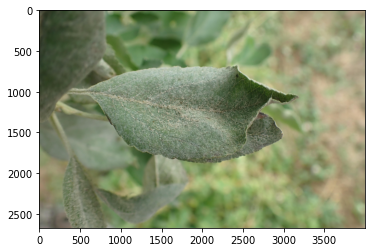

In [26]:
img=plt.imread(train_image_path+'/'+train_df['image'][0])
print(img.shape)
plt.imshow(img)
print(train_df['image'][0])

(2672, 4000, 3)
8002cb321f8bfcdf.jpg


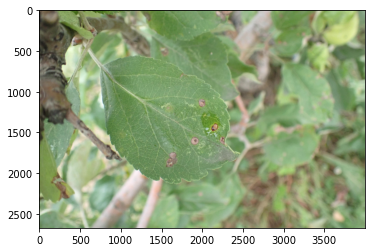

In [27]:
img=plt.imread(train_image_path+'/'+train_df['image'][1])
print(img.shape)
plt.imshow(img)
print(train_df['image'][1])

In [28]:
height,width,seed,batch_size=128,128,42,128
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)
train_dataset=train_datagen.flow_from_dataframe(train_df,
                                                directory=train_image_path,
                                                target_size=(height,width),
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed,
                                                x_col='image', y_col='labels',
                                                validate_filenames=False)


Found 15838 non-validated image filenames belonging to 12 classes.


In [29]:
validation_dataset=train_datagen.flow_from_dataframe(train_df,
                                                directory=train_image_path,
                                                target_size=(height,width),
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed,
                                                x_col='image', y_col='labels',
                                                validate_filenames=False)

Found 2794 non-validated image filenames belonging to 12 classes.


In [30]:
test_datagen=ImageDataGenerator(rescale=1./255.)
inputsize=(height,width,3)
test_dataset=test_datagen.flow_from_dataframe(test_df,
                                              directory=test_image_path,
                                              x_col='image',
                                              y_col=None,
                                              class_mode=None,
                                              shuffle=False,
                                              target_size=inputsize[:2])


Found 3 validated image filenames.


In [31]:
train_df.labels.unique()

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

In [32]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(inputsize)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(12,activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
!mkdir ./chkpt

In [36]:
!ls


chkpt	     plant-pathology-2021-fgvc8.zip  test_images  train_images
kaggle.json  sample_submission.csv	     train.csv


In [37]:
!pwd

/content/drive/MyDrive/plant_pathology


In [38]:
chkpt='./chkpt'

In [39]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt,
    monitor='val_loss',
    verbose=1,
    save_best_only=True)


In [40]:
early_stopping = EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0,
                        patience=5,
                        verbose=1
                )

In [41]:
fit = model.fit(train_dataset,
                                  validation_data=validation_dataset,
                                  epochs=3,
                                  steps_per_epoch=train_dataset.samples//batch_size,
                                  validation_steps=validation_dataset.samples//batch_size,
                                  callbacks=[model_checkpoint_callback, early_stopping]
                                 )

Epoch 1/3
123/123 [==============================] - ETA: 0s - loss: 1.7989 - accuracy: 0.3218 
Epoch 00001: val_loss improved from inf to 1.58771, saving model to ./chkpt
INFO:tensorflow:Assets written to: ./chkpt/assets
123/123 [==============================] - 4908s 40s/step - loss: 1.7989 - accuracy: 0.3218 - val_loss: 1.5877 - val_accuracy: 0.4167
Epoch 2/3
123/123 [==============================] - ETA: 0s - loss: 1.5907 - accuracy: 0.4125 
Epoch 00002: val_loss improved from 1.58771 to 1.47114, saving model to ./chkpt
INFO:tensorflow:Assets written to: ./chkpt/assets
123/123 [==============================] - 4666s 38s/step - loss: 1.5907 - accuracy: 0.4125 - val_loss: 1.4711 - val_accuracy: 0.4650
Epoch 3/3
123/123 [==============================] - ETA: 0s - loss: 1.4054 - accuracy: 0.5025 
Epoch 00003: val_loss improved from 1.47114 to 1.17143, saving model to ./chkpt
INFO:tensorflow:Assets written to: ./chkpt/assets
123/123 [==============================] - 4822s 39s/step 

In [43]:
#prediction

model = tf.keras.models.load_model("./chkpt")
preds=model.predict(test_dataset)

In [46]:
print(preds)
preds_indice=np.argmax(preds,axis=-1)
print('\n',preds_indice)

[[1.0369084e-02 1.1312179e-03 1.9755310e-04 5.3855877e-02 1.2143821e-03
  2.1666991e-05 8.8106960e-01 1.9957505e-03 1.5783207e-02 3.3194933e-02
  1.1586959e-03 8.0822456e-06]
 [2.2082323e-01 2.6287787e-02 1.7229207e-02 3.4237999e-02 4.5915204e-01
  7.9405578e-03 8.3609940e-03 3.7701410e-04 2.4421045e-03 2.4520287e-02
  1.7285669e-01 2.5772126e-02]
 [8.0758989e-02 4.4826424e-01 5.1947017e-03 8.9647599e-02 1.4816420e-01
  1.3603034e-03 3.2222595e-02 1.1502588e-03 2.0780838e-03 9.3944110e-02
  9.4504260e-02 2.7106334e-03]]

 [6 4 1]


In [49]:
def get_key(val):
    for key, value in train_dataset.class_indices.items():
        if val == value:
            return key

In [50]:
for i in range(len(preds_indice)):
    test_df["labels"] [i] = get_key(preds_indice[i])

In [51]:
test_df.head()

,image,labels
0,85f8cb619c66b863.jpg,rust
1,ad8770db05586b59.jpg,powdery_mildew
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot
